In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.models import vgg16
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

In [ ]:
train_csv_path = '../input/happy-whale-and-dolphin/train.csv'
train_df = pd.read_csv(train_csv_path)
train_df.head()

,image,species,individual_id
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9
1,000562241d384d.jpg,humpback_whale,1a71fbb72250
2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b
3,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063
4,00087baf5cef7a.jpg,humpback_whale,8e5253662392


In [ ]:
train_df.describe()

,image,species,individual_id
count,51033,51033,51033
unique,51033,30,15587
top,00021adfb725ed.jpg,bottlenose_dolphin,37c7aba965a5
freq,1,9664,400


In [ ]:
train_df.dtypes

image            object
species          object
individual_id    object
dtype: object

In [ ]:
# Get unique species
unique_species = train_df.species.unique()
unique_species

array(['melon_headed_whale', 'humpback_whale', 'false_killer_whale',
       'bottlenose_dolphin', 'beluga', 'minke_whale', 'fin_whale',
       'blue_whale', 'gray_whale', 'southern_right_whale',
       'common_dolphin', 'kiler_whale', 'pilot_whale', 'dusky_dolphin',
       'killer_whale', 'long_finned_pilot_whale', 'sei_whale',
       'spinner_dolphin', 'bottlenose_dolpin', 'cuviers_beaked_whale',
       'spotted_dolphin', 'globis', 'brydes_whale', 'commersons_dolphin',
       'white_sided_dolphin', 'short_finned_pilot_whale',
       'rough_toothed_dolphin', 'pantropic_spotted_dolphin',
       'pygmy_killer_whale', 'frasiers_dolphin'], dtype=object)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 [Text(0, 0, 'melon_headed_whale'),
  Text(1, 0, 'humpback_whale'),
  Text(2, 0, 'false_killer_whale'),
  Text(3, 0, 'bottlenose_dolphin'),
  Text(4, 0, 'beluga'),
  Text(5, 0, 'minke_whale'),
  Text(6, 0, 'fin_whale'),
  Text(7, 0, 'blue_whale'),
  Text(8, 0, 'gray_whale'),
  Text(9, 0, 'southern_right_whale'),
  Text(10, 0, 'common_dolphin'),
  Text(11, 0, 'kiler_whale'),
  Text(12, 0, 'pilot_whale'),
  Text(13, 0, 'dusky_dolphin'),
  Text(14, 0, 'killer_whale'),
  Text(15, 0, 'long_finned_pilot_whale'),
  Text(16, 0, 'sei_whale'),
  Text(17, 0, 'spinner_dolphin'),
  Text(18, 0, 'bottlenose_dolpin'),
  Text(19, 0, 'cuviers_beaked_whale'),
  Text(20, 0, 'spotted_dolphin'),
  Text(21, 0, 'globis'),
  Text(22, 0, 'brydes_whale'),
  Text(23, 0, 'commersons_dolphin'),
  Text(24, 0, 'white_sided_dolphin'),
  Text(25, 0, 'short_finned_pilot_whale'),
  Tex

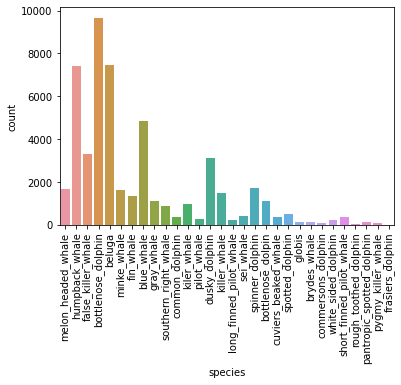

In [ ]:
# Let's see the distribution of each species
sns.countplot(train_df.species)
plt.xticks(rotation=90)

## Custom Dataset

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, df, label_to_id, transform):
        self.root_dir = root_dir
        self.df = df
        self.label_to_id = label_to_id
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        image_path = os.path.join(self.root_dir, self.df.iloc[index, 0])
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        label = self.df.iloc[index, 2]
        target = self.label_to_id[label]
        
        image = self.transform(image)
        return image, torch.tensor(target)

In [ ]:
train_transforms = transforms.Compose([transforms.ToPILImage(),
                                       transforms.Resize((56,56)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5,0.5,0.5],
                                                            [0.5,0.5,0.5])])

In [ ]:
unique_individual_ids = train_df.individual_id.unique()
unique_individual_ids

array(['cadddb1636b9', '1a71fbb72250', '60008f293a2b', ...,
       '3509cb6a8504', 'e880e47c06a4', 'bc6fcab946c4'], dtype=object)

In [ ]:
label_to_id = {}
id_to_label = {}
idx = 0
for label in unique_individual_ids:
    label_to_id[label] = idx
    id_to_label[idx] = label
    idx += 1

In [ ]:
root_dir = '../input/happy-whale-and-dolphin/train_images'

dataset = CustomDataset(root_dir,
                        train_df,
                        label_to_id,
                        train_transforms)

train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
model = vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
model.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(4096, len(label_to_id))
)

In [ ]:
for name, param in model.named_parameters():
    if 'classifier' not in name:
        param.requires_grad = False

In [ ]:
images, targets = next(iter(train_loader))
images.shape, targets.shape

(torch.Size([32, 3, 56, 56]), torch.Size([32]))

In [ ]:
output = model(images.cpu())
output.shape

torch.Size([32, 15587])

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Train model

model.to(device)
EPOCHS = 3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

last_train_loss = 0

for epoch in range(EPOCHS):
    print(f'Epoch: {epoch+1}/{EPOCHS}')
    
    correct = 0
    total = 0
    losses = []
    
    for batch_idx, data in enumerate(tqdm(train_loader)):
        images, targets = data
        images = images.to(device)
        targets = targets.to(device)
        
        output = model(images)  # (batch_size, num_classes)
        
        loss = criterion(output, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, pred = torch.max(output, 1)
        correct += (pred == targets).sum().item()
        total += pred.size(0)
        
        losses.append(loss.item())
        
    train_loss = np.mean(losses)
    train_acc = correct * 1.0 / total
    
    last_train_loss = train_loss
    print(f'Train Loss: {train_loss}\tTrain Acc: {train_acc}')

Epoch: 1/3


100%|██████████| 1595/1595 [1:16:46<00:00,  2.89s/it]


Train Loss: 8.560924294450814	Train Acc: 0.010816530480277468
Epoch: 2/3


100%|██████████| 1595/1595 [1:16:44<00:00,  2.89s/it]


Train Loss: 8.003101725862317	Train Acc: 0.016479532851292302
Epoch: 3/3


100%|██████████| 1595/1595 [1:16:42<00:00,  2.89s/it]

Train Loss: 7.766348364061696	Train Acc: 0.020006662355730606


In [ ]:
torch.save({
    'epoch': EPOCHS,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': last_train_loss
}, 'last_checkpoint.pth.tar')

# Make predictions

In [ ]:
sample_df = pd.read_csv('../input/happy-whale-and-dolphin/sample_submission.csv')
sample_df.head()

,image,predictions
0,000110707af0ba.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...
1,0006287ec424cb.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...
2,000809ecb2ccad.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...
3,00098d1376dab2.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...
4,000b8d89c738bd.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...


In [ ]:
test_transforms = transforms.Compose([transforms.ToPILImage(),
                                     transforms.Resize(56),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.5,0.5,0.5],
                                                          [0.5,0.5,0.5])])

In [ ]:
test_img_dir = '../input/happy-whale-and-dolphin/test_images'

res = []

for i in tqdm(range(sample_df.shape[0])):
    image_path = os.path.join(test_img_dir, sample_df.iloc[i,0])
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    image = test_transforms(image)
    image = image.unsqueeze(0)

    output = model(image.to(device))
    _, tk = torch.topk(output, 5, dim=1)
    pred = []
    for j in range(len(tk[0])):
        pred.append(id_to_label[tk[0][j].item()])
    pred = ' '.join(pred)
    
    sample_df.iloc[i, 1] = pred

100%|██████████| 27956/27956 [44:22<00:00, 10.50it/s]  


In [ ]:
sample_df.to_csv('submission.csv', index=False)

In [ ]:
print('Done!')

Done!
